In [1]:
################################################################################################
# MODULE IMPORT AND SETTING
################################################################################################
import numpy as np  
import pandas as pd  
from datetime import datetime

from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import RidgeCV, BayesianRidge, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

output_file = 'FINAL_SUBMISSION-20203221'

In [2]:
print('''
################################################################################################
# LOAD DATA
################################################################################################
''')
print(datetime.now(),"Load Data",)
train_dataset = pd.read_csv('./data/train.csv')
test_dataset = pd.read_csv('./data/test.csv')
print("Train set size:", train_dataset.shape)
print("Test set size:", test_dataset.shape)

train_dataset.drop(['Id'], axis=1, inplace=True)
test_dataset.drop(['Id'], axis=1, inplace=True)



################################################################################################
# LOAD DATA
################################################################################################

2020-07-03 19:34:14.987139 Load Data
Train set size: (1460, 81)
Test set size: (1459, 80)



################################################################################################
# DATA PREPROCESSING
################################################################################################


# Taking log on SalePrice
#-----------------------------------------------------



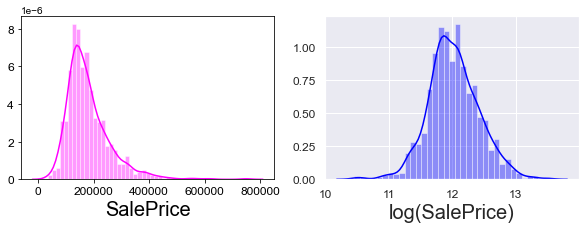

In [3]:
print(
'''
################################################################################################
# DATA PREPROCESSING
################################################################################################
'''
)
# Deleting outliers 
train_dataset = train_dataset[train_dataset.GrLivArea < 4500]
train_dataset.reset_index(drop=True, inplace=True)

# We use the numpy fuction log1p which applies log(1+x) to all elements of the column
print('''
# Taking log on SalePrice
#-----------------------------------------------------
''')
plt.figure(figsize=(10,3))
plt.subplot(121)
sns.set(font_scale=1.2)
sns.distplot(train_dataset.SalePrice,color='magenta')
plt.xlabel('SalePrice',fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(122)
sns.set(font_scale=1.2)
sns.distplot(np.log1p(train_dataset.SalePrice),color='blue')
plt.xlabel('log(SalePrice)',fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

y = np.log1p(train_dataset.SalePrice)
train = train_dataset.drop(['SalePrice'], axis=1)
test = test_dataset


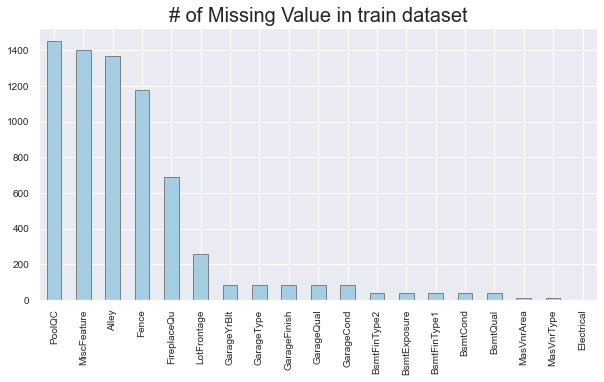

In [4]:
# Visualizing the number of NA in features
#-----------------------------------------------------
train.isnull().sum()[train.isnull().sum() > 0].sort_values(ascending=False).plot(kind='bar',cmap="Paired",fontsize=10,figsize=(10,5),edgecolor='grey')
plt.title("# of Missing Value in train dataset",size=20)
plt.show()

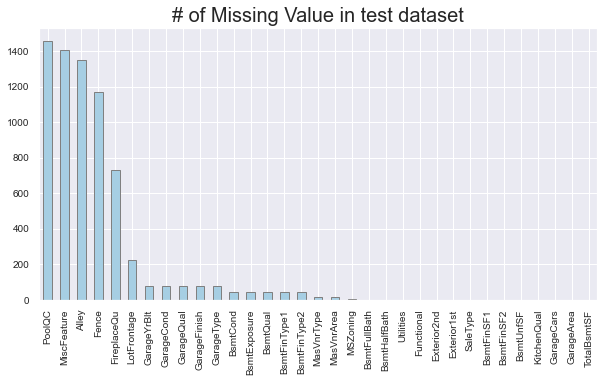

In [5]:
test.isnull().sum()[test.isnull().sum() > 0].sort_values(ascending=False).plot(kind='bar',cmap="Paired",fontsize=10,figsize=(10,5),edgecolor='grey')
plt.title("# of Missing Value in test dataset",size=20)
plt.show()

In [6]:
# Feature processing and engineering
#-----------------------------------------------------
# To preprocess features at one time, concat train and test dataset 
features = pd.concat([train, test]).reset_index(drop=True)
print("Feature shape:", features.shape)

# INT -> STR
#-----------------------------------------------------
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)


# Imputing NA's, 
#-----------------------------------------------------
# using other rows information. fill NA with modst common value or mean or 0.
features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

features['GarageYrBlt'] = features['GarageYrBlt'].fillna(0)
features['GarageArea'] = features['GarageArea'].fillna(0)
features['GarageCars'] = features['GarageCars'].fillna(0)
features['GarageType'] = features['GarageType'].fillna('None')
features['GarageFinish'] = features['GarageFinish'].fillna('None')
features['GarageQual'] = features['GarageQual'].fillna('None')
features['GarageCond'] = features['GarageCond'].fillna('None')

features['BsmtQual'] = features['BsmtQual'].fillna('None')
features['BsmtCond'] = features['BsmtCond'].fillna('None')
features['BsmtExposure'] = features['BsmtExposure'].fillna('None')
features['BsmtFinType1'] = features['BsmtFinType1'].fillna('None')
features['BsmtFinType2'] = features['BsmtFinType2'].fillna('None')

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
features['Days'] = features.apply(lambda x : (datetime(int(x.YrSold),int(x.MoSold),1)-datetime(2006,1,1)).days,axis=1)

# Filling in the rest of the NA's
#------------------------------------------------------------------------------------
# Categorical columns.
objects = [cname for cname in features.columns if features[cname].dtype == "object"]
features.update(features[objects].fillna('None'))

# Numerical columns.
numerics = [cname for cname in features.columns if features[cname].dtype != 'object']
features.update(features[numerics].fillna(0))

features.loc[(455 + len(y)),'MSZoning'] = 'RM'
features.loc[(756 + len(y)),'MSZoning'] = 'RM'
features.loc[(790 + len(y)),'MSZoning'] = 'RM'
features.loc[(1444 + len(y)),'MSZoning'] = 'RL'
features.loc[(27 + len(y)),'BsmtExposure'] = 'No'
features.loc[(580 + len(y)),'BsmtCond'] = 'TA'
features.loc[(725 + len(y)),'BsmtCond'] = 'TA'
features.loc[(757 + len(y)),'BsmtQual'] = 'Fa'
features.loc[(758 + len(y)),'BsmtQual'] = 'Fa'
features.loc[(888 + len(y)),'BsmtExposure'] = 'No'
features.loc[(1064 + len(y)),'BsmtCond'] = 'TA'

# Drop Columns with lots of missing value
features = features.drop(['Utilities', 'Street', 'PoolQC', ], axis=1) # Uncorrelated variables.

# Find columns that have high skewness
skewness_features = features[numerics].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skewness = skewness_features[skewness_features > 0.75]

# Feature Engineering : Adding and Product
#-----------------------------------------------------
features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['Total_SF']  = features['BsmtFinSF1'] + features['BsmtFinSF2'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])
features['Total_Area'] = features['TotalBsmtSF']+features['1stFlrSF']+\
                        features['2ndFlrSF']+features['GarageArea']
features['GrLivArea_OverallQual'] = features['GrLivArea'] * features['OverallQual']
features['LotArea_OverallQual'] = features['LotArea'] * features['OverallQual']

# Rescaling : Adjust Skewness
#-----------------------------------------------------
for i in high_skewness.index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

# Feature Engineering : Simplify
#-----------------------------------------------------
features['Has_Bsmt'] = features['TotalBsmtSF'].apply(lambda x : 1 if x > 0 else 0)
features['Has_Garage'] = features['GarageArea'].apply(lambda x : 1 if x > 0 else 0)
features['Has_Pool'] = features['PoolArea'].apply(lambda x : 1 if x > 0 else 0)
features['Has_FirePlace'] = features['Fireplaces'].apply(lambda x : 1 if x > 0 else 0)
features['Has_Shed'] = features['MiscFeature'].apply(lambda x : 1 if (x == "Shed") else 0)
features['Has_Gar2'] = features['MiscFeature'].apply(lambda x : 1 if (x == "Gar2") else 0)
features['Has_TenC'] = features['MiscFeature'].apply(lambda x : 1 if (x == "TenC") else 0)
features['Is_Remod'] = (features['YearBuilt'] < features['YearRemodAdd']).apply(int)

print("Before One Hot Encoding: ",features.shape)

# One hot encoding the categorical features
#-----------------------------------------------------
features = pd.get_dummies(features).reset_index(drop=True)
print("After One Hot Encoding: ", features.shape)

# Divide them into train and test datset again
#-----------------------------------------------------
X_train = features[:len(y)]
X_test = features[len(y):]
print('X_train:', X_train.shape, 'y:', y.shape, 'X_test:', X_test.shape)



Feature shape: (2917, 79)
Before One Hot Encoding:  (2917, 93)
After One Hot Encoding:  (2917, 340)
X_train: (1458, 340) y: (1458,) X_test: (1459, 340)


<Figure size 432x288 with 0 Axes>

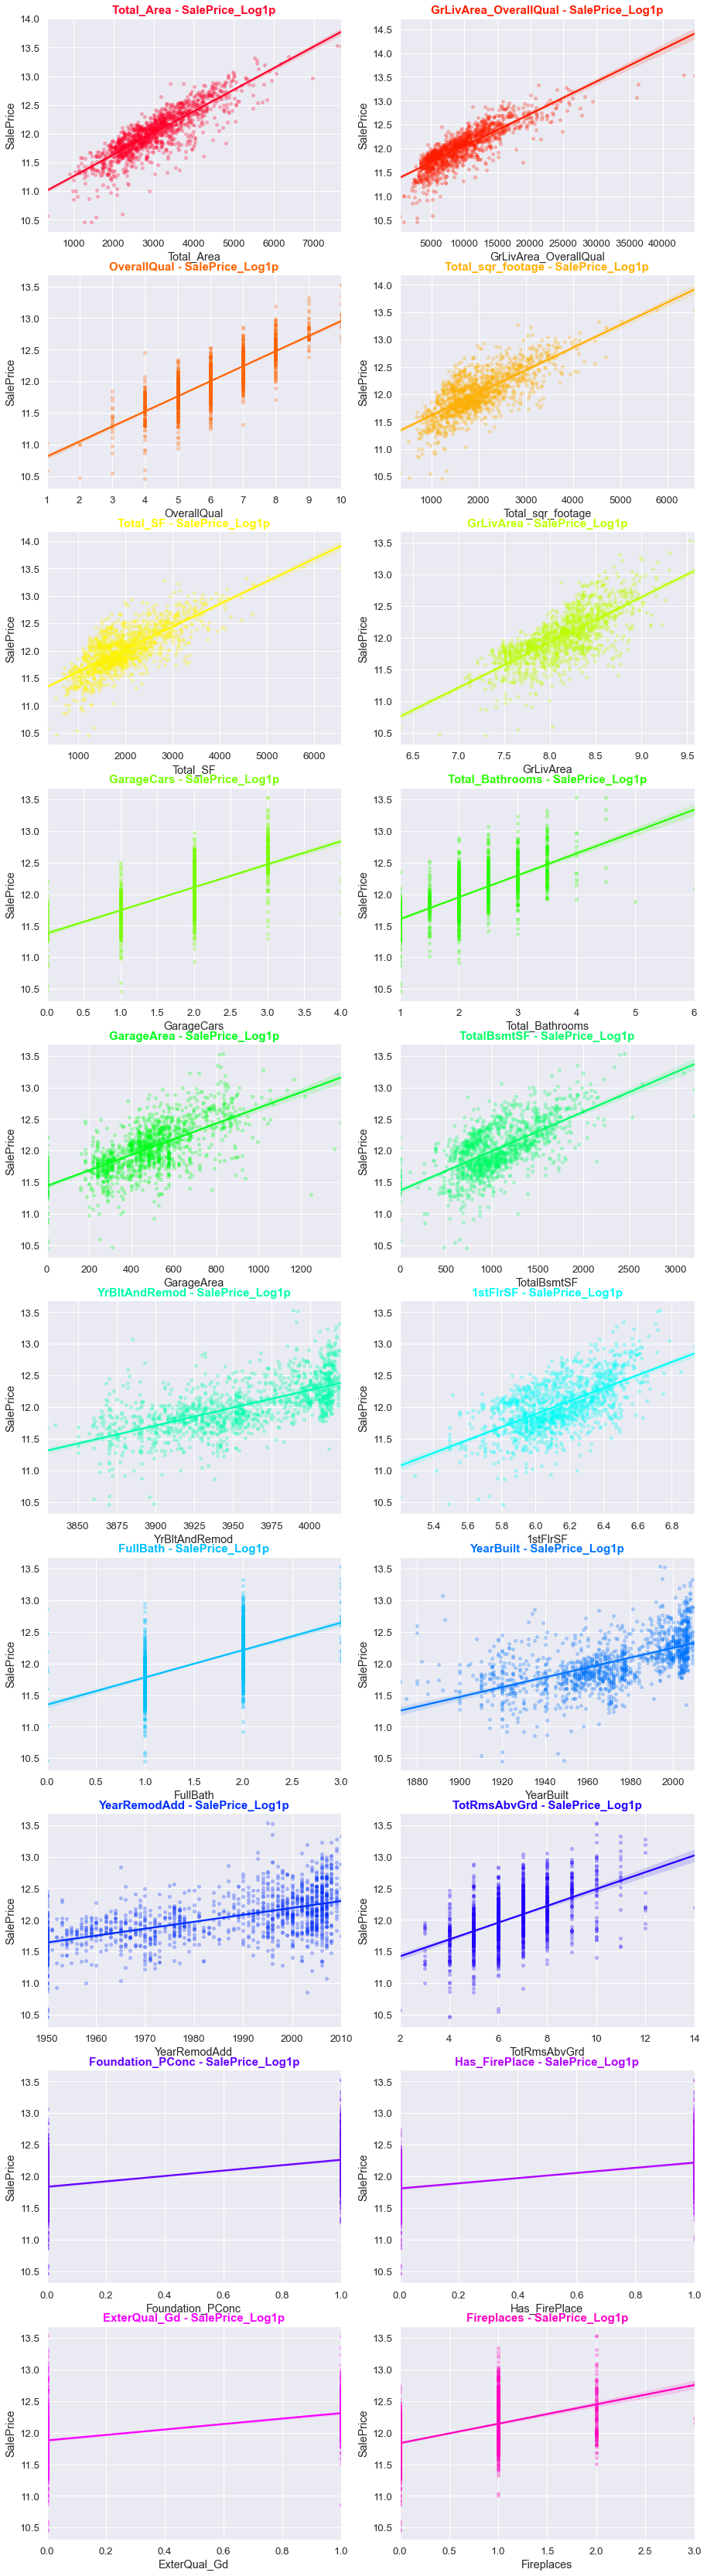

In [7]:
# Detecting Outliers using scatter plot
#-----------------------------------------------------
col = list(pd.concat([X_train,y],axis=1).corr()['SalePrice'].sort_values(ascending=False)[1:21].index)
plt.rcParams.update({'font.size': 20})

plt.subplots_adjust(wspace = 1.0, hspace=5.0)

fig, axes = plt.subplots(len(col)//2, 2,figsize=(15,60))
colors=[plt.cm.gist_rainbow(each) for each in np.linspace(0, 1, len(col))]
for i,ax,color in zip(col,axes.flatten(),colors):
    ax.set_xlabel(i)
    sns.regplot(x = X_train[i], y = y, fit_reg=True,marker='o',scatter_kws={'s':15,'alpha':0.25},color=color,ax=ax)
    ax.set_title(str(i) + ' - ' + 'SalePrice_Log1p',color=color,fontweight='bold',size=15)
plt.show()

In [8]:
# Deleting outliers, Most kaggle Notebooks deleted the below rows.
#-----------------------------------------------------
outliers = [30, 88, 462, 581, 631, 1061, 1190, 1322]
X_train = X_train.drop(X_train.index[outliers])
X_train.reset_index(drop=True,inplace=True)
y = y.drop(y.index[outliers])
y.reset_index(drop=True,inplace=True)

# Preventing Overfitting.
#-----------------------------------------------------
overfit_columns = ['MSZoning_C (all)']
for c in X_train.columns:
    counts = X_train[c].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X_train) * 100 > 99.94:
        overfit_columns.append(c)

X_train = X_train.drop(overfit_columns, axis=1).copy()
X_test = X_test.drop(overfit_columns, axis=1).copy()

print(datetime.now(),"Final Features",)
print('X_train', X_train.shape, 'y', y.shape, 'X_test', X_test.shape)

2020-07-03 19:34:28.436173 Final Features
X_train (1450, 338) y (1450,) X_test (1459, 338)


In [9]:
# Utilities
#-----------------------------------------------------
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Training
#-----------------------------------------------------
print(datetime.now(), "START MODELING")
kfolds = KFold(n_splits=10, shuffle=True, random_state=0)

alphas_ridge = [ 15.5,]
alphas_lasso = [ 0.0006,]

RIDGE = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_ridge, cv=kfolds))

BRIDGE = make_pipeline(RobustScaler(),
                      BayesianRidge(alpha_2=88.0, lambda_1=6.5, lambda_2=0.4, n_iter=1000000))

LASSO = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas_lasso,
                              random_state=0, cv=kfolds))

GBMR = GradientBoostingRegressor(
                                n_estimators=3000, 
                                learning_rate=0.05,
                                max_depth=4, 
                                max_features='sqrt',
                                min_samples_leaf=15, 
                                min_samples_split=10,
                                loss='huber', 
                                random_state=0
                                )

LGBMR = LGBMRegressor(
                        objective='regression',
                         num_leaves=4,
                         learning_rate=0.01,
                         n_estimators=5000,
                         max_bin=200,
                         bagging_fraction=0.75,
                         bagging_freq=5,
                         bagging_seed=100,
                         feature_fraction=0.2,
                         feature_fraction_seed=100,
                         verbose=-1
                         )

XGBR = XGBRegressor(
                    learning_rate=0.01, 
                    n_estimators=3500,
                    max_depth=3, 
                    min_child_weight=0,
                    gamma=0, 
                    subsample=0.7,
                    colsample_bytree=0.7,
                    reg_alpha=0.00006,
                    seed = 100
                    )
STACKING = StackingCVRegressor(regressors=(RIDGE, BRIDGE,  LASSO,
                                            GBMR, LGBMR, XGBR),
                                meta_regressor=XGBR,
                                use_features_in_secondary=True,
                                random_state = 0)


2020-07-03 19:34:28.469085 START MODELING


In [10]:
print(datetime.now(), "START FITTING")
print(datetime.now(), 'RIDGE: ',end="")
RIDGE_MODEL = RIDGE.fit(X_train, y)
print(rmsle(y, RIDGE_MODEL.predict(X_train)))

print(datetime.now(), 'BRIDGE: ',end="")
BRIDGE.fit(X_train, y)
print(rmsle(y, BRIDGE.predict(X_train)))

print(datetime.now(), 'LASSO: ',end="")
LASSO_MODEL = LASSO.fit(X_train, y)
print(rmsle(y, LASSO_MODEL.predict(X_train)))

print(datetime.now(), 'GBMR: ',end="")
GBMR.fit(X_train, y)
print(rmsle(y, GBMR.predict(X_train)))

print(datetime.now(), 'LGBMR: ',end="")
LGBMR.fit(X_train, y)
print(rmsle(y, LGBMR.predict(X_train)))

print(datetime.now(), 'XGBR: ',end="")
XGBR.fit(X_train, y)
print(rmsle(y, XGBR.predict(X_train)))

print(datetime.now(), 'STACKING: ',end="")
STACKING.fit(np.array(X_train), np.array(y))
print(rmsle(y, STACKING.predict(np.array(X_train))))

2020-07-03 19:34:28.498007 START FITTING
2020-07-03 19:34:28.498007 RIDGE:0.08869518166457854
2020-07-03 19:34:28.959772 BRIDGE:0.09055906671900005
2020-07-03 19:34:29.217084 LASSO:0.09404198259917328
2020-07-03 19:34:29.521270 GBMR:0.037755013478034755
2020-07-03 19:34:37.171811 LGBMR:0.0674133657769488
2020-07-03 19:34:38.004591 XGBR:0.045079800197082597
2020-07-03 19:34:45.909956 STACKING:0.041920150026958036


In [11]:
print('''
################################################################################################
# FINISH
################################################################################################
''')
def Arithmetic_Blending(X):
    return (
            (0.1 * RIDGE_MODEL.predict(np.array(X))) + \
            (0.35 * LGBMR.predict(X)) + \
            (0.55 * STACKING.predict(np.array(X)))#+ \
        )
print(datetime.now(),'RMSLE score on train data:', end="")
print(rmsle(y, Arithmetic_Blending(X_train)))

print(datetime.now(),'PREDICT SUBMISSION.',)
submission = pd.read_csv("./data/sample_submission.csv")
submission['SalePrice'] = np.floor(np.expm1(Arithmetic_Blending(X_test)))
submission.to_csv(output_file+"_no_brutal_force.csv", index=False)
print(datetime.now(),'SAVE SUBMISSION AT {}'.format(output_file+"_no_brutal_force.csv"))

# Brutal Force Method
#-----------------------------------------------------
print(datetime.now(),"Using Bruta Force Method.")
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.79)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*0.925)
submission.to_csv(output_file+"_no_scaling.csv", index=False)
print(datetime.now(),'SAVE SUBMISSION AT {}'.format(output_file+"_no_scaling.csv"))


################################################################################################
# FINISH
################################################################################################

2020-07-03 19:36:20.246170 RMSLE score on train data:0.05062208807359994
2020-07-03 19:36:20.621164 PREDICT SUBMISSION.
2020-07-03 19:36:20.930338 SAVE SUBMISSION AT FINAL_SUBMISSION-20203221_no_brutal_force.csv
2020-07-03 19:36:20.930338 Using Bruta Force Method.
2020-07-03 19:36:20.936322 SAVE SUBMISSION AT FINAL_SUBMISSION-20203221_no_scaling.csv


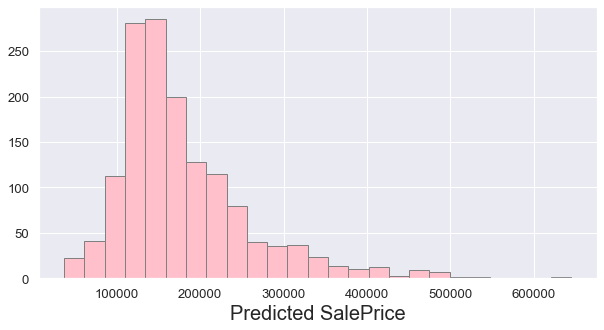

In [12]:
submission['SalePrice'].hist(color='pink', edgecolor='grey',bins=25,figsize=(10,5))
plt.xlabel("Predicted SalePrice", fontsize=20)
plt.show()

In [13]:
# Multiplying extreme edge value by a constant 
#-----------------------------------------------------
print(datetime.now(),"Rescaling Extreme Outlier.")
q3 = submission['SalePrice'].quantile(0.9999)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x:  x if x < q3 else x*0.28 )

2020-07-03 19:36:21.324307 Rescaling Extreme Outlier.


In [14]:
# Saving Final Submission
#-----------------------------------------------------
submission.to_csv(output_file+".csv", index=False)
print(datetime.now(),'SAVE SUBMISSION AT {}'.format(output_file + ".csv"))

2020-07-03 19:36:21.343235 SAVE SUBMISSION AT FINAL_SUBMISSION-20203221.csv
